<a href="https://colab.research.google.com/github/zenAurelius/HRAI3/blob/main/notebooks/test_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/HRAI/data

Mounted at /content/drive
/content/drive/MyDrive/HRAI/data


In [36]:
df = pd.read_csv('pmu2016_os.zip')
df.head()

,aid_cr,rfs_date,rfs_heure,ris_nom,rfi_prix,rfi_distance,rfs_corde,rfs_condSexe,rfi_nbPartants,rfs_hippodrome,...,pff_ord_2,OS_D_MU_pis_cheval_1,OS_D_SG_pis_cheval_1,OS_N_MU_pis_cheval_1,OS_N_SG_pis_cheval_1,OS_D_MU_pis_driver_1,OS_D_SG_pis_driver_1,OS_N_MU_pis_driver_1,OS_N_SG_pis_driver_1,pff_pwin_1
0,160101R01C02,160101,1250,D'ANGOULEME,90000,2100,CORDE_GAUCHE,TOUS_CHEVAUX,17,VIN,...,14.642893,-1.964295,0.981306,23.035705,8.177963,-1.964295,0.981306,23.035705,8.177963,0.5
1,160101R01C02,160101,1250,D'ANGOULEME,90000,2100,CORDE_GAUCHE,TOUS_CHEVAUX,17,VIN,...,14.642893,-1.964295,0.981306,23.035705,8.177963,-1.964295,0.981306,23.035705,8.177963,0.5
2,160101R01C02,160101,1250,D'ANGOULEME,90000,2100,CORDE_GAUCHE,TOUS_CHEVAUX,17,VIN,...,14.642893,-1.964295,0.981306,23.035705,8.177963,-1.964295,0.981306,23.035705,8.177963,0.5
3,160101R01C02,160101,1250,D'ANGOULEME,90000,2100,CORDE_GAUCHE,TOUS_CHEVAUX,17,VIN,...,14.642893,-1.964295,0.981306,23.035705,8.177963,-1.964295,0.981306,23.035705,8.177963,0.5
4,160101R01C02,160101,1250,D'ANGOULEME,90000,2100,CORDE_GAUCHE,TOUS_CHEVAUX,17,VIN,...,14.642893,1.964295,0.981306,26.964295,8.177963,1.964295,0.981306,26.964295,8.177963,0.5


In [37]:
# prompt: dans df on a une colonnes pfs_chSexe_1 contenant soit FEMELLES soit MALES soit HONGRES, on veut remplacer ces valeurs respectivement par F, M et H

df['pfs_chSexe_1'] = df['pfs_chSexe_1'].replace({'FEMELLES': 'F', 'MALES': 'M', 'HONGRES': 'H'})
df['pfs_chSexe_2'] = df['pfs_chSexe_2'].replace({'FEMELLES': 'F', 'MALES': 'M', 'HONGRES': 'H'})

In [38]:
# prompt: on veut dans une colonne diffSexe la concatenation de pfs_chSexe_1 et pfs_chSexe_2

df['diff_sexe'] = df['pfs_chSexe_1'].astype(str) + df['pfs_chSexe_2'].astype(str)

In [39]:
#SELECTION DES FEATURES ET TARGET
#df = df[['rfi_prix','rfi_distance','pfi_chNbPlaces_1','pff_rapportDirect_1','pff_ord_1','pfi_chNbPlaces_2','pff_rapportDirect_2','pff_ord_2','tgf_win_1']].copy()
df = df[['diff_sexe', 'pff_rapportDirect_1','pff_ord_1','pff_rapportDirect_2','pff_ord_2','tgf_win_1']].copy()
df = df[(~df.pff_rapportDirect_2.isna()) & (~df.pff_rapportDirect_1.isna())].copy()
df['diff_cote'] = df.pff_rapportDirect_1 /  (df.pff_rapportDirect_2 + df.pff_rapportDirect_1)
df['diff_ord'] = df.pff_ord_1 /  (df.pff_ord_2 + df.pff_ord_1)
df['tgf_win_1'] = df['tgf_win_1'].replace(0.5, 0)
df = df[['diff_sexe', 'pff_rapportDirect_1', 'pff_ord_1', 'diff_cote','diff_ord', 'tgf_win_1']].copy()
df.head()

,diff_sexe,pff_rapportDirect_1,pff_ord_1,diff_cote,diff_ord,tgf_win_1
0,FF,39.0,14.642893,0.795918,0.5,0.0
1,FH,39.0,14.642893,0.557143,0.5,0.0
2,FF,39.0,14.642893,0.849673,0.5,0.0
3,FM,39.0,14.642893,0.819328,0.5,0.0
4,FF,39.0,14.642893,0.280576,0.5,1.0


In [42]:
df = df[df.tgf_win_1 != 0.5]
print(len(df[(df.diff_sexe == 'FF') & (df.tgf_win_1 == 1)]) / len(df[(df.diff_sexe == 'FF')]))
print(len(df[(df.diff_sexe == 'FM') & (df.tgf_win_1 == 1)]) / len(df[(df.diff_sexe == 'FM')]))
print(len(df[(df.diff_sexe == 'FH') & (df.tgf_win_1 == 1)]) / len(df[(df.diff_sexe == 'FH')]))
print(len(df[(df.diff_sexe == 'HF') & (df.tgf_win_1 == 1)]) / len(df[(df.diff_sexe == 'HF')]))
print(len(df[(df.diff_sexe == 'HM') & (df.tgf_win_1 == 1)]) / len(df[(df.diff_sexe == 'HM')]))
print(len(df[(df.diff_sexe == 'HH') & (df.tgf_win_1 == 1)]) / len(df[(df.diff_sexe == 'HH')]))
print(len(df[(df.diff_sexe == 'MM') & (df.tgf_win_1 == 1)]) / len(df[(df.diff_sexe == 'MM')]))
print(len(df[(df.diff_sexe == 'MF') & (df.tgf_win_1 == 1)]) / len(df[(df.diff_sexe == 'MF')]))
print(len(df[(df.diff_sexe == 'MH') & (df.tgf_win_1 == 1)]) / len(df[(df.diff_sexe == 'MH')]))

0.451493860281517
0.4206901742370075
0.44371720402951986
0.47457698459466285
0.440449669580845
0.45666261752759923
0.45126154000955904
0.49394121853008693
0.4636445326394219


In [43]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])
print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


1117404 training examples
139676 validation examples
139676 test examples


In [44]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('tgf_win_1')
  df = {key: np.array(value)[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [9]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [47]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))

In [50]:
[(train_features, label_batch)] = train_ds.take(1)
test_type_col = train_features['diff_sexe']
test_type_layer = get_category_encoding_layer(name='diff_sexe',
                                              dataset=train_ds,
                                              dtype='string')
test_type_layer(test_type_col)

<tf.Tensor: shape=(256, 10), dtype=float32, numpy=
array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)>

In [51]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)


In [52]:
all_inputs = []
encoded_features = []

# Numerical features.
#for header in ['rfi_prix', 'rfi_distance', 'pfi_chNbPlaces_1', 'pff_rapportDirect_1', 'pff_ord_1', 'pfi_chNbPlaces_2', 'pff_rapportDirect_2', 'pff_ord_2']:
for header in ['pff_rapportDirect_1', 'pff_ord_1', 'diff_cote', 'diff_ord']:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

for header in ['diff_sexe']:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='string',
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

In [53]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(16, activation="relu")(all_features)
output = tf.keras.layers.Dense(1,activation="sigmoid")(x)

model = tf.keras.Model(all_inputs, output)


In [58]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=["accuracy"])


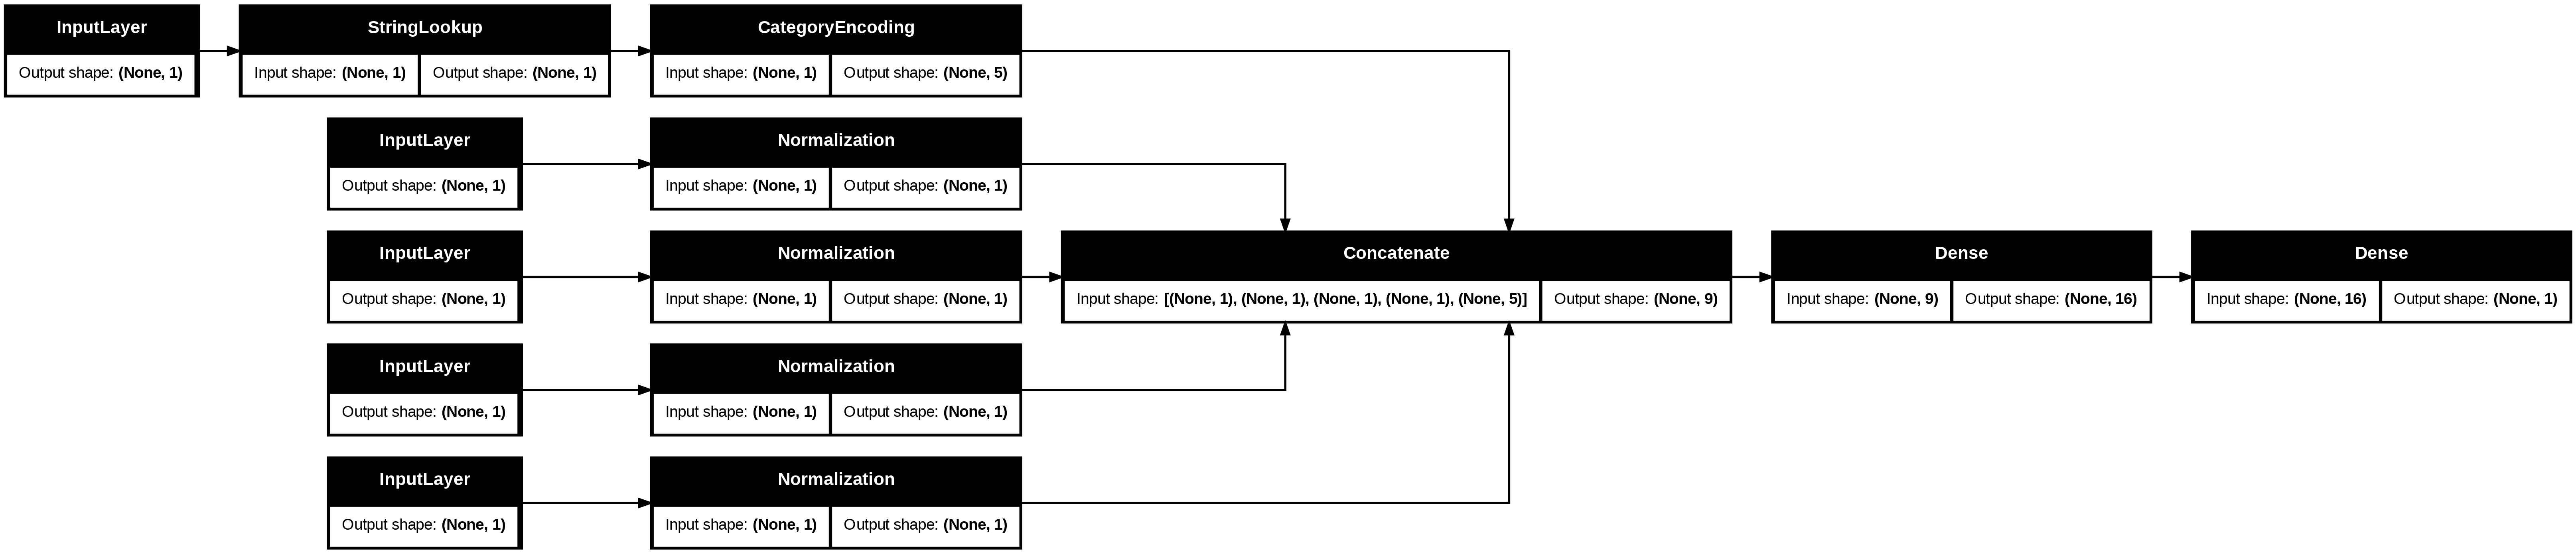

In [60]:
# Use `rankdir='LR'` to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")


In [59]:
model.fit(train_ds, epochs=10, validation_data=val_ds)


Epoch 1/10


UnimplementedError: Graph execution error:

Detected at node functional_1_1/Cast_2 defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-59-92d3d4bc7574>", line 1, in <cell line: 1>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 51, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 882, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 167, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 258, in _standardize_inputs

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 218, in _convert_inputs_to_tensors

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/core.py", line 743, in convert_to_tensor

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/core.py", line 120, in convert_to_tensor

Cast string to float is not supported
	 [[{{node functional_1_1/Cast_2}}]] [Op:__inference_one_step_on_iterator_1199716]

In [16]:
model.save('classifier_test2.keras')
reloaded_model = tf.keras.models.load_model('classifier_test.keras')

In [22]:
predictions = model.predict(test_ds)
predictions

546/546 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


array([[0.5968484 ],
       [0.611497  ],
       [0.53002363],
       ...,
       [0.34016523],
       [0.43171883],
       [0.6776906 ]], dtype=float32)

In [23]:
# prompt: je veux mettre le résultat des prédictions dans une colonne 'pred' du dataframe d'origine 'test'

# Convert predictions to a binary classification (e.g., using a threshold)
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

# Add the predictions as a new column 'pred' to the test dataframe
test['pred2'] = binary_predictions

# Print the updated dataframe with predictions
test.pred.value_counts()

,count
pred,
0,83829
1,55847


In [ ]:
test.tgf_win_1.value_counts()

,count
tgf_win_1,
0.0,76177
1.0,63499


In [19]:
# prompt: dans dataframe 'test' je veux une colonne win_cote qui contient 1 si rapport 2 > rapport 1 et 0 sinon

test['win_cote'] = (test['diff_cote'] < 0.5).astype(int)
test['win_ord'] = (test['diff_ord'] > 0.5).astype(int)

In [ ]:
test

,diff_cote,diff_ord,tgf_win_1,pred,win_cote,win_ord
1307202,0.130435,0.680025,1.0,1,1,1
545642,0.873786,0.315881,0.0,0,0,0
474746,0.227642,0.497995,0.0,1,1,0
788409,0.411765,0.437304,0.0,0,1,0
224899,0.727273,0.354621,1.0,0,0,0
...,...,...,...,...,...,...
224359,0.160839,0.587040,1.0,1,1,1
808345,0.722222,0.540763,1.0,0,0,1
586845,0.217054,0.478931,1.0,1,1,0
999082,0.385714,-0.467524,0.0,1,1,0


In [20]:
print(len(test[(test.pred == 1) & (test.tgf_win_1 == 1)]) / len(test[(test.tgf_win_1 == 1)]))
print(len(test[(test.win_cote == 1) & (test.tgf_win_1 == 1)]) / len(test[(test.tgf_win_1 == 1)]))
print(len(test[(test.win_ord == 1) & (test.tgf_win_1 == 1)]) / len(test[(test.tgf_win_1 == 1)]))
print(len(test[(test.win_cote == 1) & (test.win_ord == 1) & (test.tgf_win_1 == 1)]) / len(test[(test.tgf_win_1 == 1)]))

0.5352516390586893
0.636889114116492
0.5868780286954043
0.44352769771640327


In [ ]:
print(len(test[(test.pred == 0) & (test.tgf_win_1 == 0)]) / len(test[(test.tgf_win_1 == 0)]))
print(len(test[(test.win_cote == 0) & (test.tgf_win_1 == 0)]) / len(test[(test.tgf_win_1 == 0)]))
print(len(test[(test.win_ord == 0) & (test.tgf_win_1 == 0)]) / len(test[(test.tgf_win_1 == 0)]))

0.7122884860259658
0.6180736967851189
0.5823542539086601


In [24]:
print(len(test[(test.pred == 1) & (test.tgf_win_1 == 1)]) / len(test[(test.pred == 1)]))
print(len(test[(test.pred2 == 1) & (test.tgf_win_1 == 1)]) / len(test[(test.pred2 == 1)]))
print(len(test[(test.win_cote == 1) & (test.tgf_win_1 == 1)]) / len(test[(test.win_cote == 1)]))
print(len(test[(test.win_ord == 1) & (test.tgf_win_1 == 1)]) / len(test[(test.win_ord == 1)]))
print(len(test[(test.win_cote == 1) & (test.win_ord == 1) & (test.tgf_win_1 == 1)]) / len(test[(test.win_cote == 1) & (test.win_ord == 1)]))
print(len(test[(test.win_cote == 0) & (test.pred == 1) & (test.tgf_win_1 == 1)]) / len(test[(test.win_cote == 0) & (test.pred == 1)]))

0.6052070836392286
0.5866382810613875
0.5805748437296993
0.5366980448950036
0.6122551591465547
0.5
